# url: https://mining-activity.com/dataminig_world_happiness_report/

# Pythonで世界幸福度ランキングのデータマイニング！幸福度の高い国民がいる国の特徴とは？

世界幸福度報告といったランキングをご存じでしょうか？

2012年から毎年、世界各国それぞれの国民が自分の幸福度を0から10のどの段階であるかを回答する世論調査が行われています。世界幸福度報告では、その世論調査で得られた幸福度の数値の平均値から各国の幸福度を算出することでランキングが報告されています。

毎年、フィンランドやデンマーク、アイスランド、ノルウェーなど西ヨーロッパが上位に君臨しているようですが、我らが日本は何位くらいかご存じですか？　始まった当初は40位台でしたが、2010年代後半からは年々順位を下げ、2020年は62位まで転落しました。今年の2021年の報告では56位まで回復したようですが、経済大国の割には例年そこまで良い順位ではないようです。私個人的には、幸せな方だと思っていましたが、上には上がいるようです。

今回のこの記事では幸福度が高い国と低い国ではどんな違いがあるのか調べるために、2021年のランキングデータを用いてPythonを用いてデータマイニングしてみました。目的変数は幸福度（Ladder score）、説明変数は一人あたりGDP、社会的サポート（困ったときに助けてくれる信頼できる親類や友人がいるか）、健康寿命、人生における選択の自由、寛大さ（過去1カ月にいくら募金したか）、国の政府に対する汚職や腐敗の認知の6つです。

データ解析流れはデータ加工　→　ヒストグラム、散布図、ボックスプロットでデータ概要を把握　　→　相関解析、主成分分析（PCA）、因子分析で幸福度の増減に寄与する変数を調べるといった流れです。

In [1]:
import pandas as pd                                          # データを扱うための標準的なライブラリ
import numpy as np                                           # 多次元配列を扱う数値演算ライブラリ
import matplotlib.pyplot as plt                              # グラフを描画するライブラリ
import seaborn as sns                                        # グラフを描画するライブラリ
%matplotlib inline
# jupyter内に描画

from sklearn.decomposition import PCA,TruncatedSVD           # 主成分分析用ライブラリ

df = pd.read_csv('/content/world-happiness-report-2021.csv') # Kaggleにあります
df = df.set_index('Country name')                            # 国名をインデックスに持ってきました。
df = df.drop(["Standard error of ladder score","upperwhisker","lowerwhisker","Ladder score in Dystopia","Explained by: Log GDP per capita","Explained by: Social support","Explained by: Healthy life expectancy","Explained by: Freedom to make life choices","Explained by: Generosity","Explained by: Perceptions of corruption","Dystopia + residual"], axis=1)

# 今回は簡易的に解析するため、主要な説明変数6種以外は除きました。

df.head()

,Regional indicator,Ladder score,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Country name,,,,,,,,
Finland,Western Europe,7.842,10.775,0.954,72.0,0.949,-0.098,0.186
Denmark,Western Europe,7.620,10.933,0.954,72.7,0.946,0.030,0.179
Switzerland,Western Europe,7.571,11.117,0.942,74.4,0.919,0.025,0.292
Iceland,Western Europe,7.554,10.878,0.983,73.0,0.955,0.160,0.673
Netherlands,Western Europe,7.464,10.932,0.942,72.4,0.913,0.175,0.338


<Axes: title={'center': 'Ladder score'}, xlabel='Regional indicator'>

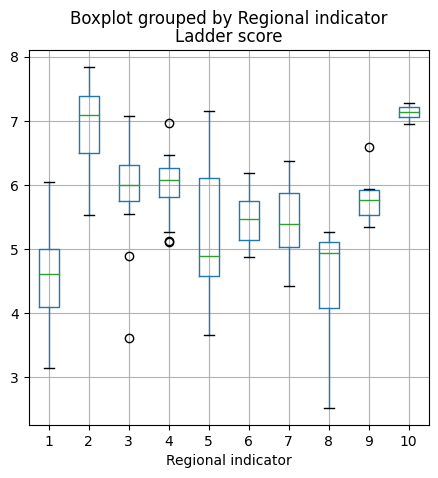

In [2]:
# まずは世界の地域ごとに幸福度の違いがありそうか、傾向をみてみましょう。Regional indicator毎に作ったグループを横軸に、幸福度を縦軸にボックスプロットを見てみます。
# 地域名が長いとグラフ描画の際の名前が見えづらいので数字に置き換えてから作図します。

df.loc[df["Regional indicator"] == "Sub-Saharan Africa", "Regional indicator"] = 1
df.loc[df["Regional indicator"] == "Western Europe", "Regional indicator"] = 2
df.loc[df["Regional indicator"] == "Latin America and Caribbean", "Regional indicator"] = 3
df.loc[df["Regional indicator"] == "Central and Eastern Europe", "Regional indicator"] = 4
df.loc[df["Regional indicator"] == "Middle East and North Africa", "Regional indicator"] = 5
df.loc[df["Regional indicator"] == "Commonwealth of Independent States", "Regional indicator"] = 6
df.loc[df["Regional indicator"] == "Southeast Asia", "Regional indicator"] = 7
df.loc[df["Regional indicator"] == "South Asia", "Regional indicator"] = 8
df.loc[df["Regional indicator"] == "East Asia", "Regional indicator"] = 9
df.loc[df["Regional indicator"] == "North America and ANZ", "Regional indicator"] = 10

df.boxplot(column='Ladder score',by='Regional indicator', figsize=(5,5))

# 西ヨーロッパと北アメリカ、ANZ（オーストラリア、ニュージーランド）の幸福度が平均的に高い結果になりました。
# 逆に低いところはサブサハランアフリカ（南アフリカ）や南アジアが低いようです。なぜなのか。アンケート結果の解析を進めましょう。

In [3]:
# 上記の処理についてのメモ
# df.loc[df["Regional indicator"] == "Sub-Saharan Africa", "Regional indicator"] = 1は、条件に合致する特定のセルに対して新しい値を割り当てるためのコードです。

# 具体的には：
# df["Regional indicator"] == "Sub-Saharan Africa": この条件は、"Regional indicator" 列が "Sub-Saharan Africa" と等しいかどうかを確認します。
# df.loc[...]: これは条件に合致する行を指定しています。
# ,"Regional indicator"]: これは条件に合致した特定の列を指定します。
# = 1: 最後に、これは条件に合致した特定のセルに 1 を代入する部分です。

# つまり、この一連のコードは "Regional indicator" 列が "Sub-Saharan Africa" の行に対して、その "Regional indicator" 列の値を 1 に変更します。



# ※ 以下の両方でも同じ出力を得ることができる
# df.loc[df["Regional indicator"] == "Sub-Saharan Africa"]
# df[df["Regional indicator"] == "Sub-Saharan Africa"]

# df.loc[df["Regional indicator"] == "Sub-Saharan Africa"] と df[df["Regional indicator"] == "Sub-Saharan Africa"] は通常、同じ結果を返します。ただし、いくつかの注意点があります。
# 結果が同じであること: 条件に一致する行を取り出すという基本的な目的では、両者は同じです。両者とも条件に一致する行のサブセットを含むデータフレームを返します。

# df_selected_loc = df.loc[df["Regional indicator"] == "Sub-Saharan Africa"]
# df_selected_boolean = df[df["Regional indicator"] == "Sub-Saharan Africa"]

# 両者の結果が同じであることを確認
# print(df_selected_loc.equals(df_selected_boolean))  # True
# 行と列の指定の柔軟性: df.loc は行と列の両方を指定できるのに対し、ブールインデックス参照（df[]）は行のみを指定するため、df.loc は行と列の両方を同時に選択する場合に便利です。

# 行と列を同時に指定
# df_selected_loc = df.loc[df["Regional indicator"] == "Sub-Saharan Africa", ["Regional indicator", "Ladder score"]]
# 条件が複数の列にまたがる場合: もし条件が複数の列にまたがる場合、.loc を使用して特定の条件を指定する方が柔軟です。

# "Column1" と "Column2" の両方の条件が満たされる行を取得
# df_selected_loc = df.loc[(df["Column1"] == "Value1") & (df["Column2"] == "Value2")]

# 総じて、基本的な条件であれば、どちらを使用しても同じ結果が得られますが、特定の条件で異なる結果を期待する場合や、行と列を同時に操作する場合は .loc を使用すると良いでしょう。
    # └ ほんとか笑?? 好みの問題??



# df.loc[df["Regional indicator"] == "Sub-Saharan Africa"] は df.loc[df["Regional indicator"] == "Sub-Saharan Africa", :] と同等です。
# df.loc を使用する場合、行と列の両方を指定できるため、行の条件だけ指定する場合は , : を省略しても同じ結果が得られます。
# 言い換えれば、:`` は全ての列を指定するため、:`` を省略することで全列を選択していることになります。


# column='Ladder score': これはボックスプロットの対象となる数値データの列です。ボックスプロットはこの列のデータに基づいて描かれます。
# by='Regional indicator': これはボックスプロットを描く際に、各カテゴリ（"Regional indicator" 列の値ごと）に基づいてデータを分割するための列です。各カテゴリごとにボックスプロットが描かれます。
# このようにして、数値データをカテゴリごとに比較するボックスプロットが描かれます。
# データフレームの "Ladder score" 列がボックスプロットの描画対象となり、"Regional indicator" 列の各カテゴリごとに分割されます。

# df.boxplot(column='Ladder score', by='Regional indicator', figsize=(5,5)) を実行すると、Pandasが裏でいくつかの統計計算を実行し、それに基づいてボックスプロットが可視化されます。

# このコードが行う主な処理は以下の通りです：
#     データのグループ化: "Regional indicator" 列の値に基づいてデータをグループ化します。
#     各グループの統計計算: 各グループごとに "Ladder score" 列の統計情報を計算します。これには中央値、四分位範囲（IQR）、外れ値の範囲などが含まれます。
#     ボックスプロットの描画: 計算された統計情報を元に、Matplotlibを使用してボックスプロットを描画します。
# ボックスプロットは、各グループの分布の中央傾向や散らばりなどを視覚的に比較するのに役立ちます。
# 箱は四分位範囲 (IQR) を表し、中央の線は中央値を示しています。ヒゲは外れ値の範囲を表します。

# したがって、df.boxplot(column='Ladder score', by='Regional indicator', figsize=(5,5)) を実行することで、データのグループごとの "Ladder score" 列の分布を比較するボックスプロットが描かれます。



# 一般的に、ilocの方がlocよりも処理が速い傾向があります。これは、ilocが整数ベースの位置指定を使用するためです。
# 一方で、locはラベルを使用してデータを選択するため、ラベルが整数であっても、ilocよりもわずかに遅いことがあります。

# ilocは整数ベースの位置にアクセスするので、特に数値型のインデックスを持つデータフレームでの操作に適しています。
# 一方で、locはラベルを指定するため、インデックスが整数でない場合や、ラベルが整数でも意味的に異なる場合に使用されます。

# ただし、速度の差は通常微小であり、データセットのサイズや操作の複雑さによっても変化する可能性があります。
# データセットのサイズや操作の性質によっては、実際のコードで両者を試してみてどちらが適しているかを検討することが良いでしょう。

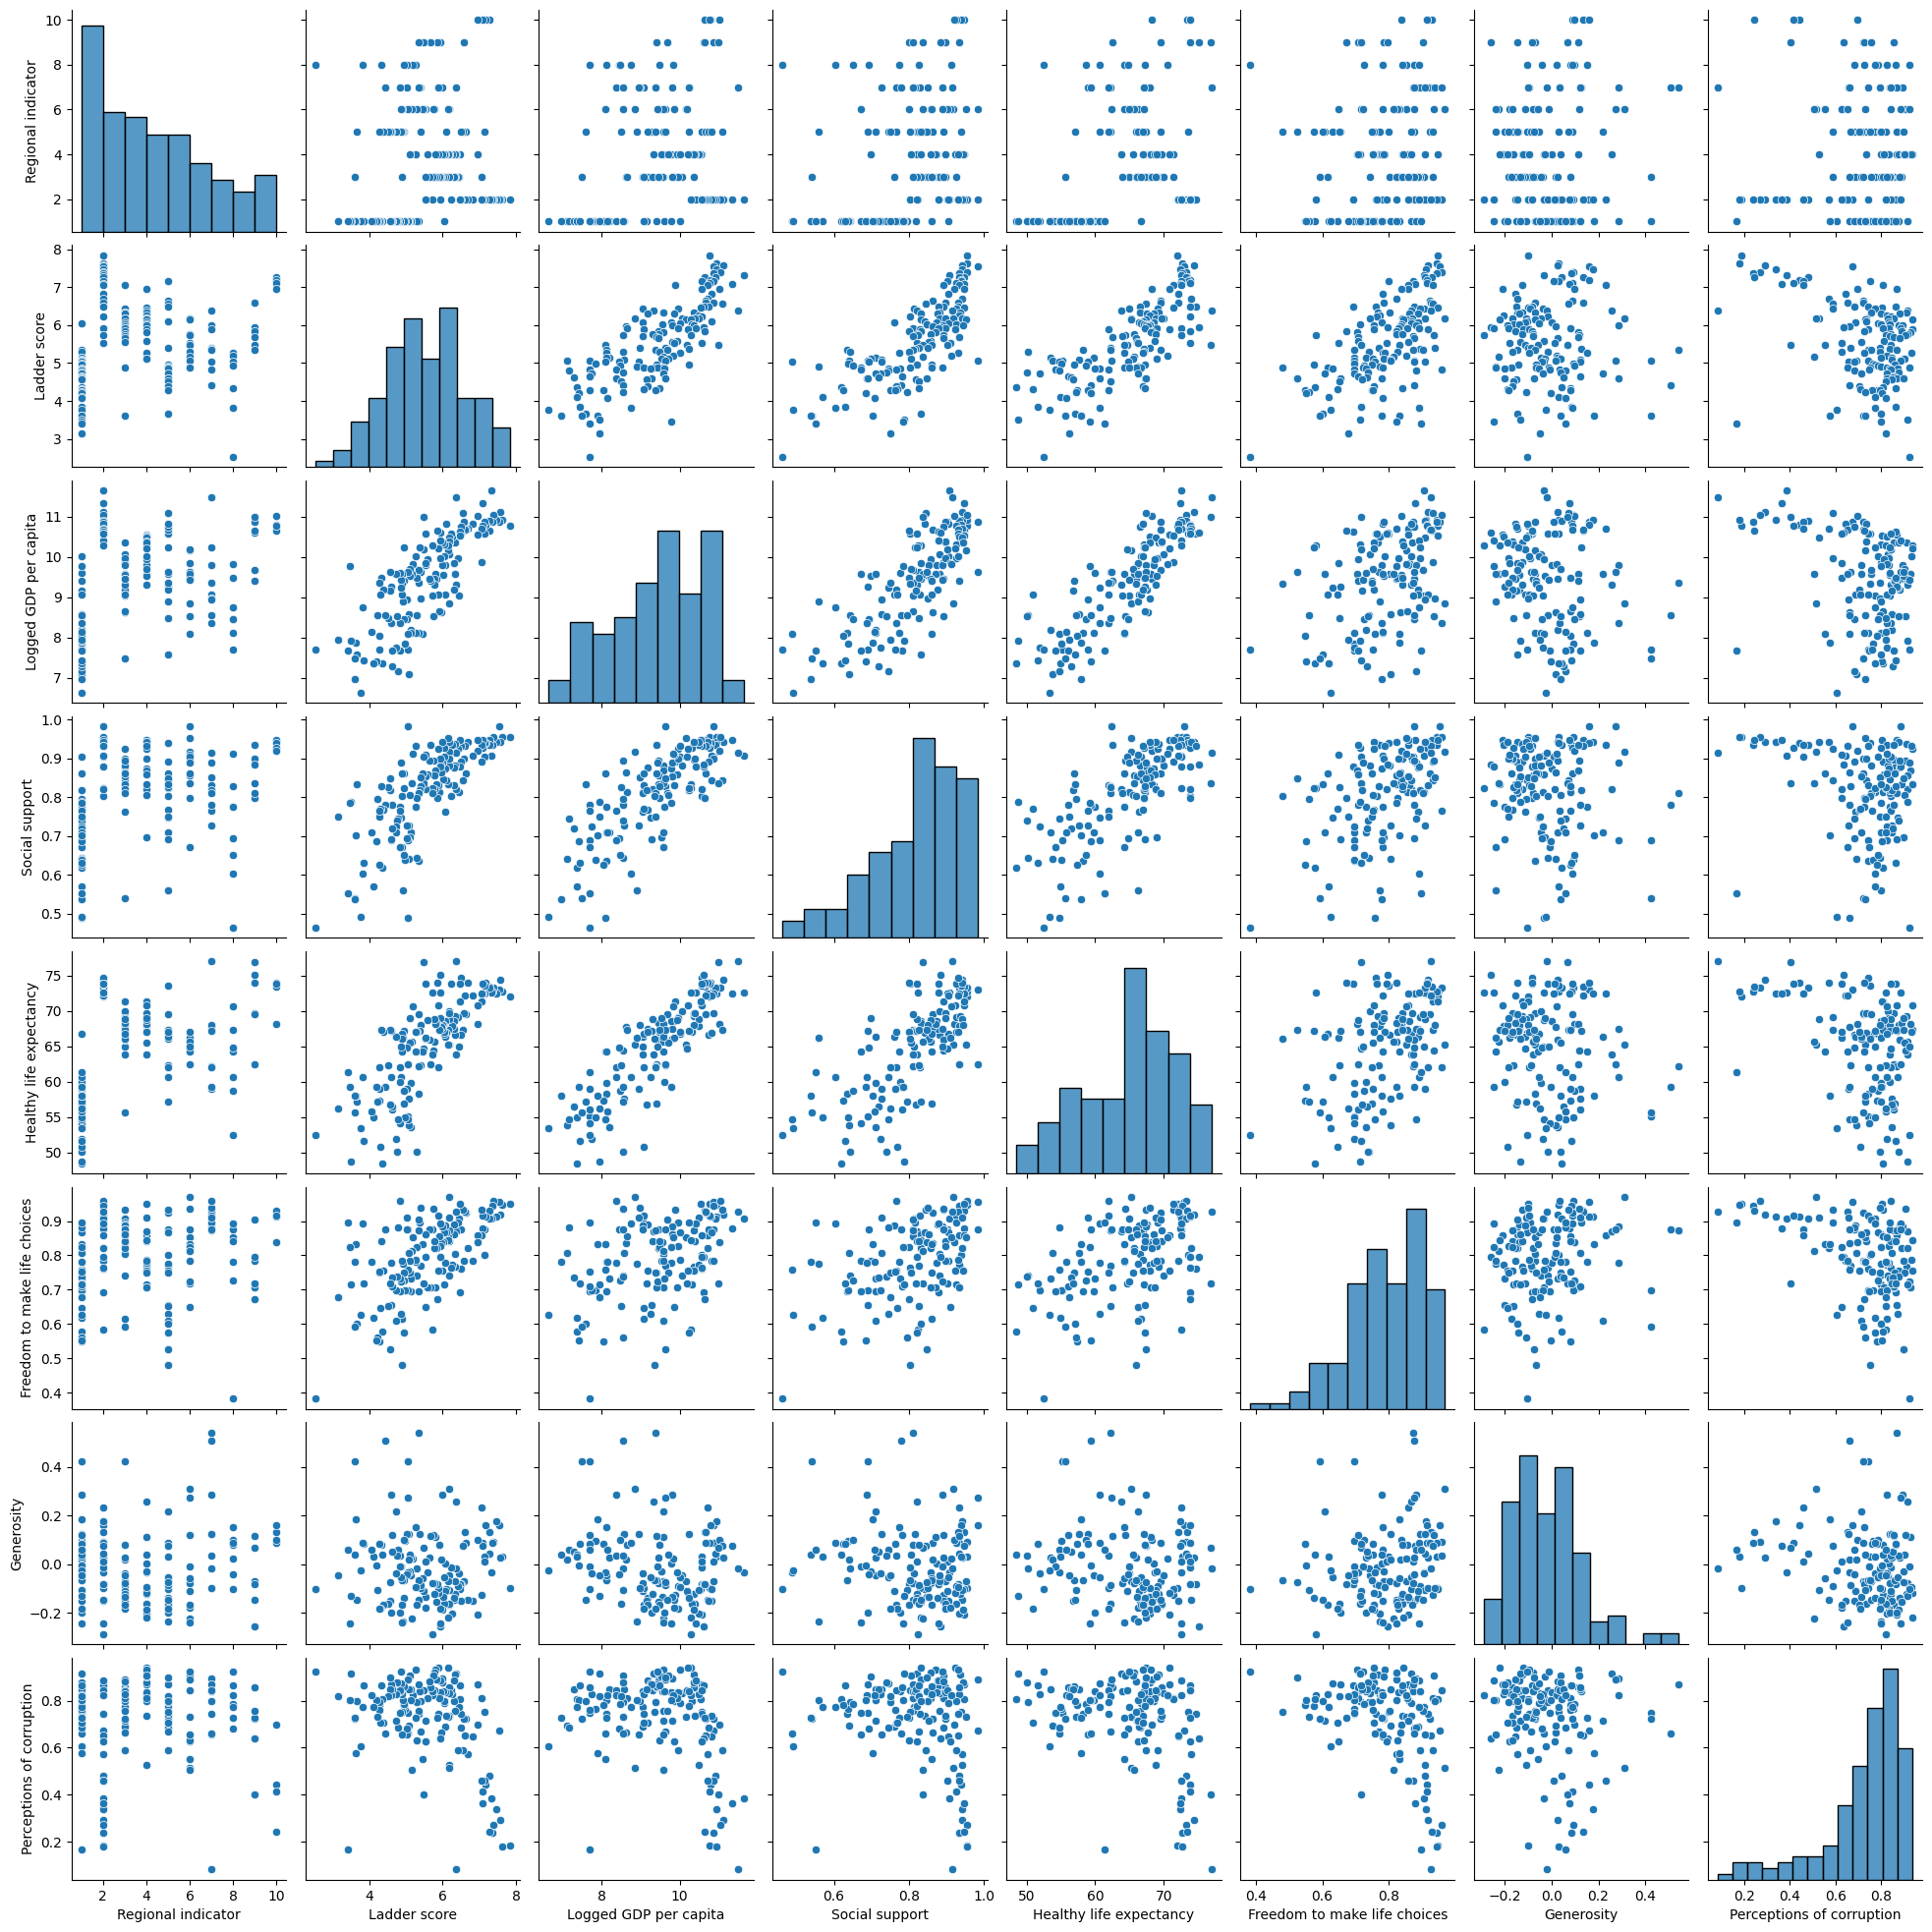

In [4]:
# ヒストグラムと散布図でデータの分布をみてみます。
sns.pairplot(df)
plt.show()

# 一番左上ヒストグラムを見ると幸福度は10点中6点の国が一番多いようです。散布図を見てみると、1人当たりのGDP、社会サポート、健康寿命、選択の自由は幸福度と正の相関がありそうです。
# 逆に国民の国の汚職や腐敗の認知が高い国は幸福度と負の相関がありそうです。実際にピアソンの相関解析でみてみましょう。

<ipython-input-5-623103578d8c>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns_heatmap = sns.heatmap(df.corr(), cmap=sns.color_palette("coolwarm",10), annot=True, fmt=".2f", vmin=-1, vmax=1,ax=ax, square=True)


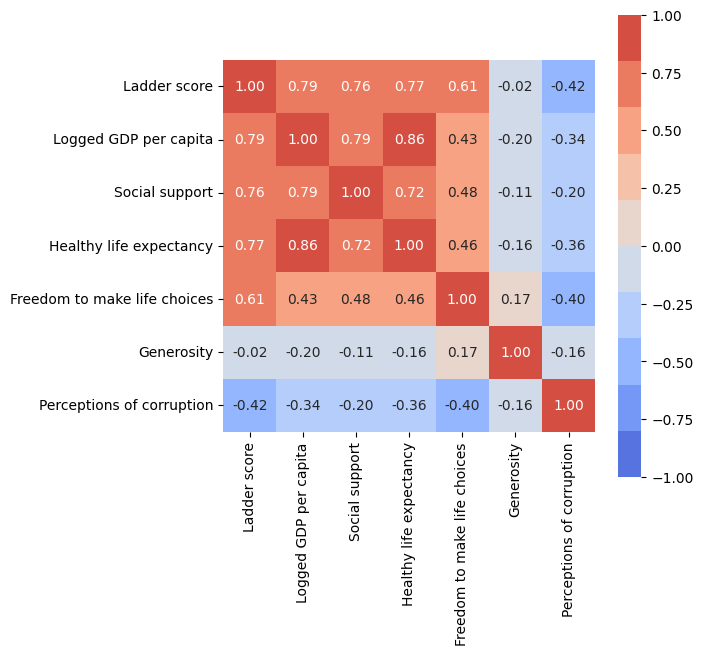

In [5]:
# ピアソンの相関解析
fig, ax     = plt.subplots(figsize=(6, 6))
sns_heatmap = sns.heatmap(df.corr(), cmap=sns.color_palette("coolwarm",10), annot=True, fmt=".2f", vmin=-1, vmax=1,ax=ax, square=True)

# 散布図の結果で予測した通りでしたね。
# では幸福度と正の相関がある4つの説明変数の中でも、特に重要な因子、つまり幸福に一番寄与することは何なのか解析をすすめて考察してみましょう。
# 主成分分析と因子分析を行います。

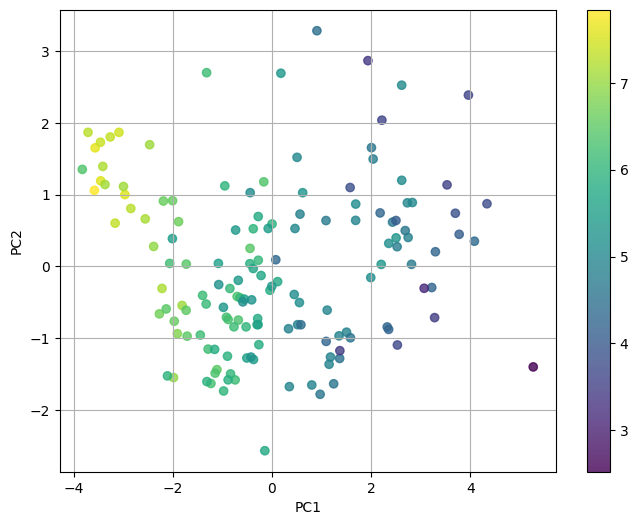

In [6]:
# 主成分分析と因子分析

#標準化
dfs = df.iloc[:, 0:].apply(lambda x: (x-x.mean())/x.std(), axis=0)

#主成分分析の実行
pca = PCA()
pca.fit(dfs)

# データを主成分空間に写像
feature = pca.transform(dfs)

# 主成分得点
pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(dfs.columns))]).head()

# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(8, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=list(df.iloc[:,1])) #カラーはLadder score
plt.colorbar()
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# 丸い点一つ一つが国を表します。色は幸福度スコアを表すので、PC1<0になればなるほど幸福度が高く、PC1>0になればなるほど幸福度が低い国が分布しているのがわかります。
# では因子分析で幸福度に寄与する変数を考察していきましょう。

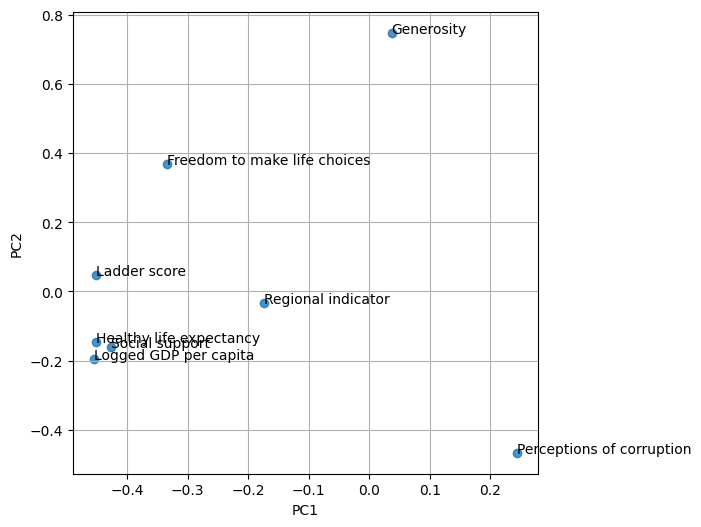

In [7]:
#因子分析
plt.figure(figsize=(6, 6))
for x, y, name in zip(pca.components_[0], pca.components_[1], dfs.columns[0:]):
    plt.text(x, y, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# ヒストグラムと相関解析で見た通り、幸福度が高い国が分布していた付近（PC<0）には一人あたりのGDP,社会サポート、健康寿命、選択の自由が分布しているので、これらが高い幸福度に寄与することはやはり間違いなさそうです（感覚的にもそうですけど(笑)）。
# 負に寄与するのも変わらず汚職と腐敗ですね。

# では4つの中で一番寄与が大きいのはどれでしょうか？より詳細に主成分分析の結果をみてみましょう。
# 幸福度が高い国はPC1<0かつPC2>0に存在するのがわかります。因子分析ではいかがでしょうか？
# 該当箇所（PC1<0かつPC2>0）に存在しているのは選択の自由でした。
# 以上の結果から特に高い幸福度に寄与しているのは人生における選択の自由であるということが示唆されました。

In [8]:
# 【所感】

# お金があること、経済活動が活発であること、信頼できる友達がたくさんいれば、それだけ人生における選択の自由も増えそうですもんね。
# 幸福になる上で大事なこと、個人的には勉強することをやめないことかと思ってます。

# いくつになってもたくさん知ること、色々な分野を勉強すること　→　自分でできる仕事が増える。本職でも副業でも。　→　お金が生まれる　 →　選択の自由が増える（やりたいことをやる。なにもやらないでニート生活、ざまざま）　→　　また新しいことに投資（勉強でも仕事でも）ができる　→　お金が生まれる　→　・・・→選択の自由が増える　→　勉学から生まれる幸福のスパイラル？

# 経済大国の日本は2021年は56位ですもんね。経済が豊かでも、残業してる時間が特に長い国で有名ですし、 お金だけあろうが、仕事で時間が縛られてるのでその他への選択の自由が無いが故に国民の幸福度上がらないって感じなのでしょうか。。。。(笑)。
# 決められた枠内の仕事だけで日々カツカツでストレスフルな生活は送りたくないって私自身も思います。そう思うと、やっぱり選択の自由が大きいほど、人生が豊かで幸せっていうのもうなずけます。うん。

# 自由な時間ができて選択の自由もふえて幸福な毎日を送れるはず。

# 今回は2021年だけのデータで見ているので限定的な分できです。
# 2012年から遡れば国毎に幸福度がどのように推移してきたのか、 質問項目の回答はどう変わってきたのかを調べれば、項目ごとの増減が幸福度増減に与える影響の大きさもわかるはずです。
# コロナ渦中では例年比べて人々の考えがどう変わったのかなどなど。 気になる人はやってみてください＾＾！